# MLP - `FER-2013` Dataset

In [1]:
# !gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8 -O "data/FER-2013.zip"

In [24]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [25]:
random_sate = 59
np.random.seed(random_sate)
torch.manual_seed(random_sate)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_sate)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# !unzip "data/FER-2013.zip" -d "data/FER-2013/"

In [27]:
train_dir = "data/FER-2013/train"
test_dir = "data/FER-2013/test"

### Data Processing

In [28]:
classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

idx2label

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [29]:
test_img_path = "data/FER-2013/train/angry/Training_10118481.jpg"
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)

print(f"Image Height: {img_height}")
print(f"Image Width: {img_width}")

Image Height: 128
Image Width: 128


### DataLoader

In [30]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split="train", train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()
        
        if split in ["train", "val"] and "train" in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size= train_ratio,
                random_state=59,
                stratify=self.img_labels
            )
            
            if split == "train":
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == "val":
                self.img_paths, self.img_labels = zip(*val_data)
    
    def read_img_files(self):
        img_paths, img_labels = [], []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)
        return img_paths, img_labels
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img/127.5) - 1
        return img, label

In [31]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, split="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split="val")
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split="test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Visualize

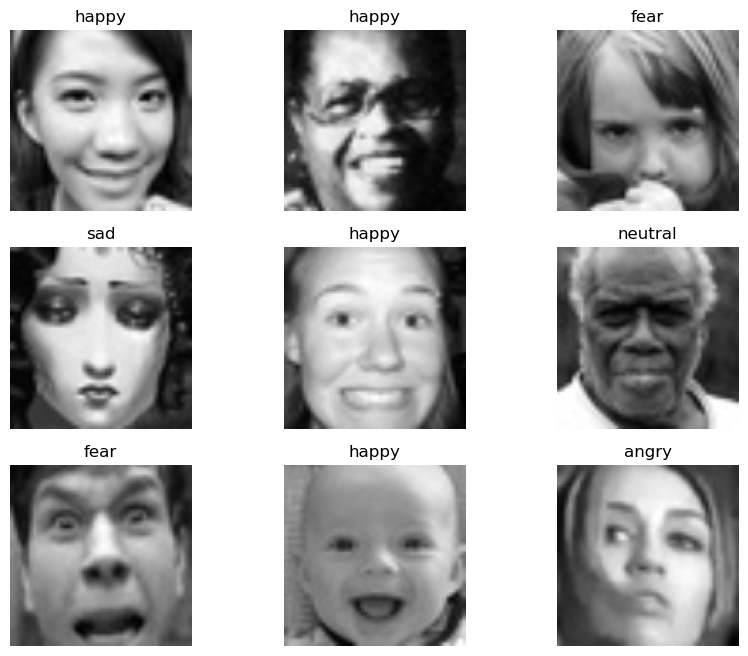

In [32]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")
plt.show()

### MLP

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)
    
model = MLP(
    input_dims=img_height*img_width,
    hidden_dims=64,
    output_dims=len(classes)    
).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [33]:
def compute_accuracy(y_pred, y):
    _, y_pred = torch.max(y_pred, dim=1)
    correct = (y_pred == y).sum().item()
    accuracy = correct / len(y)
    return accuracy

In [15]:
epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, train_predict = [], []
    
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_samples)
        
        loss = criterion(outputs, y_samples)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target, val_predict = [], []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    
    print(f"\nEpoch {epoch+1}: \tTraining loss: {train_loss:.3f} \tValidation loss: {val_loss:.3f}")
    


Epoch 1: 	Training loss: 1.920 	Validation loss: 1.896

Epoch 2: 	Training loss: 1.869 	Validation loss: 1.846

Epoch 3: 	Training loss: 1.823 	Validation loss: 1.809

Epoch 4: 	Training loss: 1.792 	Validation loss: 1.783

Epoch 5: 	Training loss: 1.769 	Validation loss: 1.762

Epoch 6: 	Training loss: 1.747 	Validation loss: 1.741

Epoch 7: 	Training loss: 1.726 	Validation loss: 1.719

Epoch 8: 	Training loss: 1.704 	Validation loss: 1.698

Epoch 9: 	Training loss: 1.682 	Validation loss: 1.680

Epoch 10: 	Training loss: 1.665 	Validation loss: 1.665

Epoch 11: 	Training loss: 1.651 	Validation loss: 1.654

Epoch 12: 	Training loss: 1.637 	Validation loss: 1.645

Epoch 13: 	Training loss: 1.626 	Validation loss: 1.637

Epoch 14: 	Training loss: 1.616 	Validation loss: 1.631

Epoch 15: 	Training loss: 1.608 	Validation loss: 1.630

Epoch 16: 	Training loss: 1.598 	Validation loss: 1.618

Epoch 17: 	Training loss: 1.590 	Validation loss: 1.615

Epoch 18: 	Training loss: 1.581 	Valida

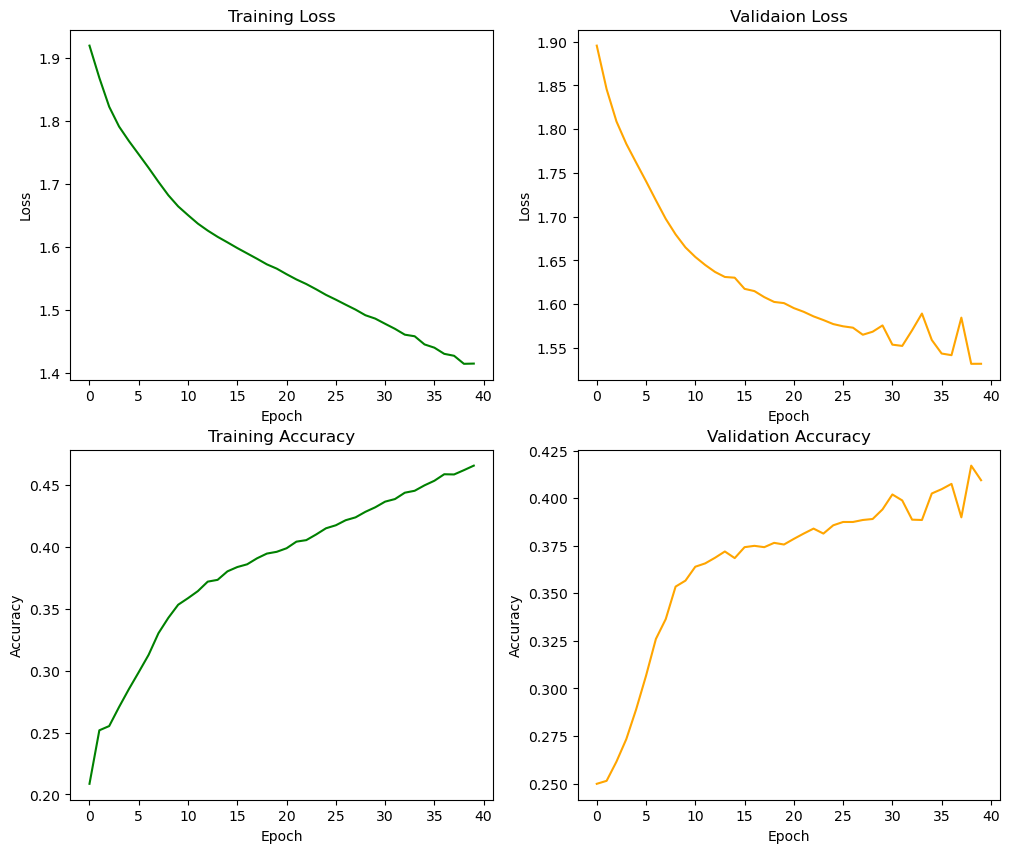

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses, color="green")
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, color="orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validaion Loss")

ax[1, 0].plot(train_accs, color="green")
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, color="orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")

plt.show()

In [17]:
test_target, test_predict = [], []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        outputs = model(X_samples)
        
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    val_acc = compute_accuracy(test_predict, test_target)
    
    print("Evaluation on test set: ")
    print(f"Accuracy: {val_acc}")

Evaluation on test set: 
Accuracy: 0.4122318194483143


### Question 10.1

In [11]:
class MLP101(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP101, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)
    
model = MLP101(
    input_dims=img_height*img_width,
    hidden_dims=64,
    output_dims=len(classes)    
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, train_predict = [], []
    
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_samples)
        
        loss = criterion(outputs, y_samples)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target, val_predict = [], []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    
    print(f"\nEpoch {epoch+1}: \tTraining loss: {train_loss:.3f} \tValidation loss: {val_loss:.3f}")

test_target, test_predict = [], []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        outputs = model(X_samples)
        
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    val_acc = compute_accuracy(test_predict, test_target)
    
    print("Evaluation on test set: ")
    print(f"Accuracy: {val_acc}")


Epoch 1: 	Training loss: nan 	Validation loss: nan

Epoch 2: 	Training loss: nan 	Validation loss: nan

Epoch 3: 	Training loss: nan 	Validation loss: nan

Epoch 4: 	Training loss: nan 	Validation loss: nan

Epoch 5: 	Training loss: nan 	Validation loss: nan

Epoch 6: 	Training loss: nan 	Validation loss: nan

Epoch 7: 	Training loss: nan 	Validation loss: nan

Epoch 8: 	Training loss: nan 	Validation loss: nan

Epoch 9: 	Training loss: nan 	Validation loss: nan

Epoch 10: 	Training loss: nan 	Validation loss: nan

Epoch 11: 	Training loss: nan 	Validation loss: nan

Epoch 12: 	Training loss: nan 	Validation loss: nan

Epoch 13: 	Training loss: nan 	Validation loss: nan

Epoch 14: 	Training loss: nan 	Validation loss: nan

Epoch 15: 	Training loss: nan 	Validation loss: nan

Epoch 16: 	Training loss: nan 	Validation loss: nan

Epoch 17: 	Training loss: nan 	Validation loss: nan

Epoch 18: 	Training loss: nan 	Validation loss: nan

Epoch 19: 	Training loss: nan 	Validation loss: nan

E

### Question 10.2

In [34]:
class MLP102(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP102, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)
    
model = MLP102(
    input_dims=img_height*img_width,
    hidden_dims=64,
    output_dims=len(classes)    
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, train_predict = [], []
    
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_samples)
        
        loss = criterion(outputs, y_samples)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target, val_predict = [], []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    
    print(f"\nEpoch {epoch+1}: \tTraining loss: {train_loss:.3f} \tValidation loss: {val_loss:.3f}")

test_target, test_predict = [], []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        outputs = model(X_samples)
        
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    val_acc = compute_accuracy(test_predict, test_target)
    
    print("Evaluation on test set: ")
    print(f"Accuracy: {val_acc}")


Epoch 1: 	Training loss: 1.858 	Validation loss: 1.798

Epoch 2: 	Training loss: 1.769 	Validation loss: 1.750

Epoch 3: 	Training loss: 1.725 	Validation loss: 1.711

Epoch 4: 	Training loss: 1.688 	Validation loss: 1.680

Epoch 5: 	Training loss: 1.660 	Validation loss: 1.660

Epoch 6: 	Training loss: 1.639 	Validation loss: 1.645

Epoch 7: 	Training loss: 1.623 	Validation loss: 1.636

Epoch 8: 	Training loss: 1.610 	Validation loss: 1.627

Epoch 9: 	Training loss: 1.598 	Validation loss: 1.618

Epoch 10: 	Training loss: 1.587 	Validation loss: 1.611

Epoch 11: 	Training loss: 1.576 	Validation loss: 1.605

Epoch 12: 	Training loss: 1.566 	Validation loss: 1.597

Epoch 13: 	Training loss: 1.556 	Validation loss: 1.595

Epoch 14: 	Training loss: 1.546 	Validation loss: 1.590

Epoch 15: 	Training loss: 1.537 	Validation loss: 1.584

Epoch 16: 	Training loss: 1.528 	Validation loss: 1.580

Epoch 17: 	Training loss: 1.519 	Validation loss: 1.578

Epoch 18: 	Training loss: 1.509 	Valida

### Question 10.3

In [35]:
class MLP103(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP103, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.linear3 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)
    
model = MLP103(
    input_dims=img_height*img_width,
    hidden_dims=64,
    output_dims=len(classes)    
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

epochs = 40
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, train_predict = [], []
    
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_samples)
        
        loss = criterion(outputs, y_samples)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target, val_predict = [], []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    
    print(f"\nEpoch {epoch+1}: \tTraining loss: {train_loss:.3f} \tValidation loss: {val_loss:.3f}")

test_target, test_predict = [], []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        outputs = model(X_samples)
        
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    val_acc = compute_accuracy(test_predict, test_target)
    
    print("Evaluation on test set: ")
    print(f"Accuracy: {val_acc}")


Epoch 1: 	Training loss: 1.911 	Validation loss: 1.877

Epoch 2: 	Training loss: 1.849 	Validation loss: 1.831

Epoch 3: 	Training loss: 1.815 	Validation loss: 1.809

Epoch 4: 	Training loss: 1.797 	Validation loss: 1.795

Epoch 5: 	Training loss: 1.785 	Validation loss: 1.785

Epoch 6: 	Training loss: 1.775 	Validation loss: 1.775

Epoch 7: 	Training loss: 1.766 	Validation loss: 1.765

Epoch 8: 	Training loss: 1.754 	Validation loss: 1.752

Epoch 9: 	Training loss: 1.740 	Validation loss: 1.734

Epoch 10: 	Training loss: 1.720 	Validation loss: 1.714

Epoch 11: 	Training loss: 1.699 	Validation loss: 1.694

Epoch 12: 	Training loss: 1.679 	Validation loss: 1.677

Epoch 13: 	Training loss: 1.662 	Validation loss: 1.663

Epoch 14: 	Training loss: 1.648 	Validation loss: 1.654

Epoch 15: 	Training loss: 1.637 	Validation loss: 1.646

Epoch 16: 	Training loss: 1.627 	Validation loss: 1.640

Epoch 17: 	Training loss: 1.619 	Validation loss: 1.636

Epoch 18: 	Training loss: 1.611 	Valida